# Shor's Algorithm


## Introduction

Integer factorization [[1](#IntegerFactor)] is a famous problem in number theory: given a number $N$ which is composite, find its prime factors. The importance of the problem stems from the fact that no efficient (polynomial-time, in the number of bits needed to represent $N$) classical algorithm is known for it to this day, and much of modern day cryptography relies on this fact. In 1994, Peter Shor came up with an efficient _quantum_ algorithm for the problem [[2](#Shor94)] - providing, arguably, the most important evidence for an exponential advantage of quantum computing over classical computing.

### The full Algorithm

Shor's algorithm consists of a classical part and a quantum subroutine. The steps of the algorithm for factoring an input number $N$, summarized from [[3](#ShorSteps)], are as follows:

1. Pick a random number $1 < a < N$ that is co-prime with $N$. Co-primality can be checked by computing the GCD (greatest common divisor) of $a$ and $N$ - if it is 1 then we have found a co-prime $a$, otherwise we have found a non-trivial factor of $N$ and we are done.
2. Find the period $r$ of the following function, using the quantum period finding algorithm (described in [[3](#ShorSteps)]): $$f(x) = a^x\hspace{-8pt} \mod \hspace{-4pt} N$$
3. If $r$ is odd or $a^{r/2} = -1 \mod N$, return to step 1 (this event can be shown to happen with probability at most $1/2$).
4. Otherwise, $\gcd(a^{r/2} \pm 1, N)$ are both factors of $N$, and computing one of them yields the required result.


### Quantum period finding

The quantum part of Shor's algorithm - the period finding is simply quantum phase estimation (QPE) applied to the unitary $U$ which computes multiplication by $a$ modulo $N$: $U|y\rangle =|ya \hspace{-6pt}\mod \hspace{-4pt} N\rangle$[[4](#NielsenChuang)]. This unitary is applied to the input state $|y=1\rangle$ which is an equal superposition of $r$ eigenstates of $U$ ($r$ being the period we wish to find) with eigenvalues 
$\exp (2\pi i s/r)$,  $s = 0, ... ,r-1$. The measured output of the QPE circuit would therefore be a number which is a good approximation to $s/r$ for some $s < r$. The denominator $r$ can be found with some additional classical post-processing [[4](#NielsenChuang)]. 
The repeated applications of $U^{2^{j}}$ in the QPE algorithm are realized by multiplying with the corresponding powers $a^{2^{j}}$ modulo $N$. The resulting computation (of the repeated multiplications) is exponentiation modulo $N$. The general scheme of the QPE realizing the quantum order finding is shown in the following figure.     


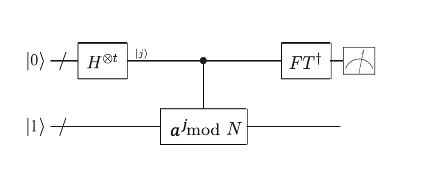

The above QPE scheme includes three components 

* A Hadamard transform applied to a first $t=2n$ qubit register at the begining of the circuit (t is set by the required accuracy and probability of success [[4](#NielsenChuang)])
* An inverse QFT applied to the same register at the end 
* A modular exponentiation applied to the first and a second $n$ qubit register computing $a^{j}\hspace{-6pt}\mod \hspace{-4pt} N$ for each of the values $j$ in the first register

Clearly, the most difficult component to implement is the modular exponentiation which will require additional auxiliary qubits. 
Here we construct a circuit implementing the above period finding algorithm receiving classical numbers $N$ and $a$ as input and returns (with a good probability) a measured output which is a good approximation to the rational number $s/r$ above.    
We start from modular addition, via modular multiplication to modular exponentiation and the full period finding circuit. The modular adder used here is a version of the QFT-based addition of Draper [[5](#Draper)] and is similar to the circuit suggested in [[6](#Beauregard)]. More generally, the period finding circuit here is similar to implementation of [[6](#Beauregard)] except for the fact that the modular exponentiation and the Quantum Fourier Transform (QFT) at the end are realized on a full register of $2n$ qubits (not on a single qubit as in [[6](#Beauregard)]) and the circuit therefore includes $4n+2$ qubits.   

## Modular Addition
The basic building block in the modular exponentiation function is the doubly controlled modular adder in the Fourier space. This circuit relies on adders in the Fourier space, which add a classical number $a$ to a quantum register, and consist solely of single qubit phase gates as shown in the figure below [[6](#Beauregard)].

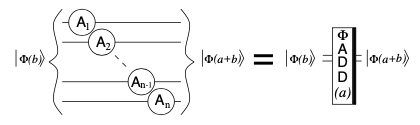

The modular adder calculates $|\phi(b)\rangle \rightarrow |\phi(b+a)\hspace{-8pt}\mod N\rangle$ where $|\phi(b)\rangle = QFT|b\rangle$ is the input to the circuit and $a$ and $N$ are classical values hardwired into the circuit (specifically into the phases of the adder and inverse adder circuits). the input $|\phi(b)\rangle$ $(b < N)$ is encoded into an $n+1$ qubit register where $n$ in the size of $N$ such that the most significant bit of the register is an overflow bit which is zero at the input and the output of the circuit. The circuit includes three adder functions and two inverse adders (subtractors) in the Fourier space as shown in the figure below [[6](#Beauregard)] (the a thick bar on the right/left side denotes an adder/inverse adder).  


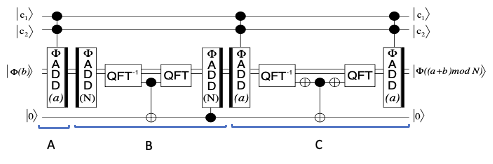

Dividing the circuit into 3 subcircuits and assuming that both control qubits are in state $|1\rangle$ the state evolevs as follows:

- In subcircuit A the value $a$ is added to $b$, that is: $|\phi(b)\rangle \rightarrow |\phi(a+b)\rangle$ 
- In subcircuit B $N$ is subtracted from $a+b$ and then added again if $N < a+b$ – this is done by checking the msb of $\phi(a+b)$ which will be in the state $|1\rangle$ iff $N < a+b$. The value of the msb is checked by applying inverse QFT to the b-register and copying the state of the msb to an auxiliary qubit and conditioning the addition of $N$ on the auxiliary qubit.
- In subcircuit C the auxiliary qubit is reset to $|0\rangle$, disentangling it from the b-register. this is done by first subtracting $a$ from the b-register checking whether the msb and fliping the auxiliary qubit if the msb is in state $|0\rangle$ and re-adding $a$ to the register.

In a first step we define a QFT function without swap gates. In subcircuits B and C above there is no need to introduce swap gates to (required for keeping the order of the qubits in a register). We simply keep track of the msb (which after the QFT will be at the the lsb position) and apply the CNOT gate to the 'correct' qubit. The order will be reversed again after the application of the second QFT in each circuit. In other QFT functions (used later in modular multiplication and at the end of the circuit) we keep the swap gates for clarity.



In [1]:
import math

from classiq import (
    CCX,
    CPHASE,
    CX,
    PHASE,
    H,
    Output,
    Preferences,
    QArray,
    QBit,
    QParam,
    X,
    allocate,
    apply_to_all,
    bind,
    control,
    create_model,
    invert,
    qft,
    qfunc,
    repeat,
    show,
    synthesize,
)
from classiq.qmod.symbolic import pi


@qfunc
def my_qft_step(qbv: QArray[QBit]) -> None:
    H(qbv[0])
    repeat(
        count=qbv.len - 1,
        iteration=lambda index: CPHASE(pi / 2 ** (index + 1), qbv[0], qbv[index + 1]),
    )


# qft without SWAP gates
@qfunc
def qft_ns(qbv: QArray[QBit]) -> None:
    repeat(
        count=qbv.len,
        iteration=lambda index: my_qft_step(qbv[index : qbv.len]),
    )

The function `ccmod_add` implements the modular adder which adds the (classical) number $a$ to the b-register modulo $N$ in the QFT space. the function recieves $a$ and $N$ as `QParams` of integers. The un-controlled, controlled and doubly controlled adders in the QFT space are implemented by the function `phase_lad`. The functions which check the msb of the b-register and conditionally flip the auxiliary qubit is `check_msb`. Notice that at this stage, as we don't use SWAP after the QFT, the msb is the first qubit.

In [2]:
from classiq.qmod import QNum, bind, quantum_if, within_apply
from classiq.qmod.builtins.classical_functions import qft_const_adder_phase


@qfunc
def phase_lad(
    value: QParam[int],
    phi_b: QArray[QBit],
) -> None:
    repeat(
        count=phi_b.len,
        iteration=lambda index: PHASE(
            theta=qft_const_adder_phase(index, value, phi_b.len), target=phi_b[index]
        ),
    )


@qfunc
def ctrl_x(ref: QParam[int], ctrl: QNum, aux: QBit) -> None:
    quantum_if(ctrl == ref, lambda: X(aux))


@qfunc
def check_msb(ref: QParam[int], x: QArray[QBit], aux: QBit) -> None:
    within_apply(lambda: invert(lambda: qft_ns(x)), lambda: ctrl_x(ref, x[0], aux))


@qfunc
def ccmod_add(
    N: QParam[int],
    a: QParam[int],
    phi_b: QArray[QBit],  # b in fourier basis
    c1: QBit,
    c2: QBit,
    aux: QBit,
) -> None:
    ctrl = QArray("ctrl")
    bind([c1, c2], ctrl)
    control(lambda: phase_lad(a, phi_b), ctrl)
    invert(lambda: phase_lad(N, phi_b))
    check_msb(1, phi_b, aux)
    control(lambda: phase_lad(N, phi_b), aux)
    within_apply(
        lambda: invert(lambda: control(lambda: phase_lad(a, phi_b), ctrl)),
        lambda: check_msb(0, phi_b, aux),
    )
    bind(ctrl, [c1, c2])

The phases for the QFT-based quantum adder are generated using the builtin-function `qft_const_adder_phase`, which implements the following logic:

```python
def qft_const_adder_phase(bit_index: int, value: int, reg_len: int) -> int:
    bit_array = [int(bit) for bit in bin(value)[2:].zfill(reg_len)]
    return sum(2 * pi / (2**(pos_index+1)) for pos_index in range(reg_len - bit_index) if \
               bit_array[bit_index + pos_index])
```

In order to check the modular addition circuit we create a main function which includes the `ccmod_add` between a QFT at the beginning and an inverse QFT at the end. We set the classical input the modulo number (15) and the classical value to add (9), and set the input state of the b-register by applying X-gates to chosen qubits (here we flipped the forth qubit so the value of the register is 8).

In [3]:
from classiq import show, synthesize, write_qmod
from classiq.qmod import QNum, inplace_prepare_int

modulo_num = 15
reg_len = math.ceil(math.log(modulo_num, 2)) + 1
a_num = 9

b_initial_value = 8


@qfunc
def main(b: Output[QNum], ctrl: Output[QArray[2]], aux: Output[QBit]) -> None:
    allocate(reg_len, b)
    allocate(2, ctrl)
    allocate(1, aux)

    # set initial values for the addition
    inplace_prepare_int(b_initial_value, b)
    X(ctrl[0])
    X(ctrl[1])

    # perform the addition in fourier basis and then transform back
    within_apply(
        lambda: qft(b), lambda: ccmod_add(modulo_num, a_num, b, ctrl[0], ctrl[1], aux)
    )


qmod = create_model(main)

write_qmod(qmod, "doubly_controlled_modular_adder")

Once we have created a model of the circuit, we can synthesize it and view the circuit.

In [4]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: http://localhost:4200/circuit/3fbb0685-d9be-46ab-9caf-414276f2cec8?version=0.0.0


We now can execute the synthesized circuit on a simulator (we use the default aer-simulator) and check the outcome. 

In [5]:
from classiq import execute

results = execute(qprog).result()
res = results[0].value

print(res.parsed_states)

{'01100010': {'b': 2.0, 'ctrl': 3.0, 'aux': 0.0}}


As expected the value of the b-register is $2=8+9 \hspace{-4pt}\mod \hspace{-3pt}15$

## Modular multiplication
A controlled modular multiplication circuit which receives as input $b$ (in the b-register) and $x$ in additional x-register and outputs $|(b+xa) mod N\rangle$ is comprised of repeated application of the doubly controlled modular adder adding $2^{i}a$ for $i=0,...,n-1$ where one of the controls in each of the modular adder is the suitable qbit of the x-register as in the following figure [[6](#Beauregard)].

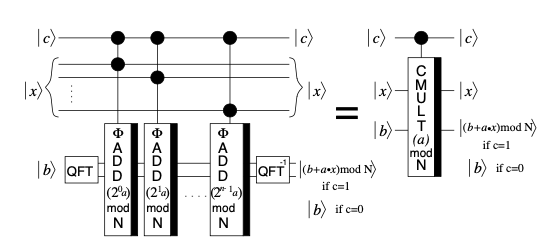

The `cmod_mult` function implements the above circuit and.

In [6]:
@qfunc
def cmod_mult(
    N: QParam[int],
    a: QParam[int],
    b: QArray[QBit],
    x: QArray[QBit],
    ctrl: QBit,
    aux: QBit,
) -> None:
    within_apply(
        lambda: qft(b),
        lambda: repeat(
            count=x.len,
            iteration=lambda index: ccmod_add(
                N, (a * (2**index)) % N, b, x[index], ctrl, aux
            ),
        ),
    )

The above circuit outputs the state $|(b+xa) \mod N\rangle$ in the b-register (assuming the control is in state $|1\rangle$) however the required output is $|xa \mod N\rangle$. This output can be obtained by conditionally swapping the b and x registers and applying the inverse of the modular multiplication circuit for the $a^{-1} \mod N$ classical value with input $b=0$, as in the following construction [[6](#Beauregard)].
  

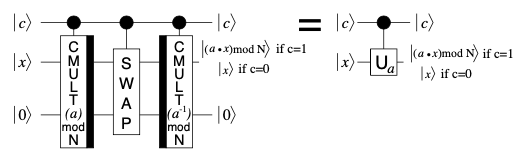

After the swap the x and b registers are in the state $|ax\hspace{-6pt} \mod \hspace{-4pt}N\rangle|x\rangle$ and the inverse multiplication function (by $a^{-1}$) will send them to the state 
$|ax\hspace{-6pt} \mod\hspace{-4pt} N\rangle|x- a^{-1}ax\rangle = |ax \mod N\rangle|0\rangle$. Thus, the x-register carries the required output while the state of the b-register is $|0\rangle$ at the output. The `cmod_mult_pair` function implements this circuit using the `c_swap` and `creg_swap` functions which implement swap between qubits and registers respectively.    

In [7]:
from classiq.qmod import SWAP, free
from classiq.qmod.symbolic import min, mod_inverse


@qfunc
def multi_swap(x: QArray[QBit], y: QArray[QBit]) -> None:
    repeat(
        count=min(x.len, y.len),
        iteration=lambda index: SWAP(x[index], y[index]),
    )


@qfunc
def cmod_mult_pair(
    N: QParam[int],
    a: QParam[int],
    x: QArray[QBit],
    ctrl: QBit,
    aux: QBit,
) -> None:
    b = QArray("b")
    allocate(x.len + 1, b)

    cmod_mult(
        N,
        a,
        b,
        x,
        ctrl,
        aux,
    )
    control(lambda: multi_swap(x, b), ctrl)
    pass
    invert(
        lambda: cmod_mult(
            N,
            mod_inverse(a, N),
            b,
            x,
            ctrl,
            aux,
        )
    )
    free(b)

## Modular Exponentiation
The above circuit can be applied repeatedly to achieve modular exponentiation. Specifically, taking an $m$ qubit register carrying value $M$ and applying the `cmod_mult_pair` function in $M$ times in sequence cascading the control over the qubits of m-register multiplying by values $a^{2^{0}}, ..., a^{2^{m-1}}$ will take the input state $|M\rangle_{m}|1\rangle_{x}|0\rangle_{b}$ to the output state 
$|M\rangle_{m}|a^{M}\mod N\rangle_{x}|0\rangle_{b}$ as required (for clarity subscripts were added to identify the registers). The `mod_exp_fuc` below implements the modular exponentiation, and accepts the classical numbers $N$ and $a$.


In [8]:
@qfunc
def mod_exp_func(
    N: QParam[int],
    a: QParam[int],
    x: QArray[QBit],
    m: QArray[QBit],
    aux: QBit,
) -> None:
    repeat(
        count=m.len,
        iteration=lambda index: cmod_mult_pair(
            N, (a ** (2**index)) % N, x, m[index], aux
        ),
    )

## Quantum Period Finding
Using the modular exponentiation function it is straightforward to implement the complete period finding algorithm - one needs to apply the Hadamard transform to the m-register at the beginning of the circuit and an inverse QFT at the end. 

In [9]:
from classiq import Constraints
from classiq.qmod import hadamard_transform

modulo_num = 6
reg_len = math.ceil(math.log(modulo_num, 2)) + 1
a_num = 5


@qfunc
def main(
    x: Output[QArray[QBit]],
    power: Output[QArray[2 * (reg_len - 1)]],
    aux: Output[QBit],
) -> None:
    allocate(reg_len - 1, x)
    allocate(2 * (reg_len - 1), power)
    allocate(1, aux)

    hadamard_transform(power)
    inplace_prepare_int(1, x)

    mod_exp_func(
        modulo_num,
        a_num,
        x,
        power,
        aux,
    )
    invert(lambda: qft(power))

In [10]:
constraints = Constraints(max_width=14)
qmod = create_model(main, constraints=constraints)
write_qmod(qmod, "shor_modular_exponentiation")

qprog = synthesize(qmod)
show(qprog)

Opening: http://localhost:4200/circuit/79166b1f-3c12-4bcb-b20b-31eaf1eafca7?version=0.0.0


In [11]:
from classiq import execute

results = execute(qprog).result()
res = results[0].value

In [12]:
res.parsed_counts

[{'x': 1.0, 'power': 0.0, 'aux': 0.0}: 259,
 {'x': 5.0, 'power': 32.0, 'aux': 0.0}: 259,
 {'x': 5.0, 'power': 0.0, 'aux': 0.0}: 254,
 {'x': 1.0, 'power': 32.0, 'aux': 0.0}: 228]

We obtained two results for the qutput register (the m-register) $32$ and $0$ each with probability roughly $1/2$. Interperted correctly as binary fractions (dividing by $2^{6}=64$) these are $0$ and $1/2$. Indeed the period is the denominator of the first result $2$.   

## References

<a id='IntegerFactor'>[1]</a>: [Integer Factorization (Wikipedia)](https://en.wikipedia.org/wiki/Integer_factorization)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='ShorSteps'>[3]</a>: [Shor's Algorithm Procedure (Wikipedia)](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure)

<a id='Nielsenchuang'>[4]</a>: Nielsen, Michael A. & Isaac L. Chuang (2001), "Quantum computation and quantum information", Cambridge Univ. Press. tific. ISBN 978-9812388582

<a id='Draper'>[5]</a>: [T. G. Draper, Addition on a Quantum Computer, 2000.](https://arxiv.org/pdf/quant-ph/0008033.pdf)

<a id='Beauregard'>[6]</a>: [S. Beauregard, "Circuit for Shor’s algorithm using 2n+3 qubits", Quantum Information & computation, Vol 3, Issue 2, 2003.](https://arxiv.org/pdf/quant-ph/0205095.pdf)
